# Primerjava pristopov za luščenje ključnih besed na izhodiščnih podatkih Schutz 2008

V tem zvezku predstavljamo primerjavo pristopov za luščenje ključnih besed iz nabora besedil [Schutz 2008](http://citeseerx.ist.psu.edu/viewdoc/summary?doi=10.1.1.394.5372). Korpus sestavlja 1.231 člankov s področja medicine (PubMed Central), pri čemer ključne besede podajo avtorji člankov.

Predstavili bomo objektivno primerjavo pristopov za luščenje besed. Primerjali bomo izluščene besede s ključnimi besedami, ki so jih označili avtorji člankov. Za vsako metodo bomo prikazali povprečno natančnost (precision), priklic (recall) in mero F1.

In [1]:
import string
import ast

import nltk
from textsemantics.server_api import ServerAPI
from nltk.tokenize import RegexpTokenizer
from nltk.corpus import stopwords
from lemmagen.lemmatizer import Lemmatizer
from lemmagen import DICTIONARY_ENGLISH
from matplotlib import pyplot as plt
import yake
from gensim.summarization import keywords as gensim_kw
import rake

from utils import specific_words
from utils.scores import (
    precision, recall, average_precision, average_recall, average_f_score,
    take_n, score_in_len_range
)

Naložimo metapodatke in dokumente iz zbirke _schutz2008_ - medicinski strokovni članki s skladišča PubMed Central. Dokumente preprocesiramo in izluščimo posamezne besede.

In [2]:
from nltk.stem.snowball import SnowballStemmer
nltk.download('stopwords', quiet=True)
# lemmatizer = Lemmatizer(dictionary=DICTIONARY_ENGLISH)
snow_stemmer = SnowballStemmer(language='english')
stop_words = set(stopwords.words('english'))

def preprocess(corpus):
    tokenizer = RegexpTokenizer("\w+")
    preprocessed = list()
    for text in corpus:
        text = text.translate(text.maketrans('', '', string.punctuation))
        tokens = tokenizer.tokenize(text.lower())
        tokens = [snow_stemmer.stem(token) for token in tokens if token not in stop_words 
                  and len(token) > 2 and not token.isnumeric()]
        # lematizer in rare cases produce empty strings - removing them
        tokens = list(filter(lambda a: a != '', tokens))  
        preprocessed.append(tokens)
        
    return preprocessed

api = ServerAPI()
metadata = api.get_metadata('schutz2008')
# stolpec s ključnimi besedami vsebuje seznam zapisan kot niz - pretvori v seznam
metadata["Keywords"] = metadata["Keywords"].apply(lambda x: x.split(';'))
# pretvorba ključnih besed v posamezne besede in lematizacija
tokenizer = RegexpTokenizer("\w+")
metadata["Keywords_one_word"] = metadata["Keywords"].apply(
    lambda ph: list(set([snow_stemmer.stem(w.lower()) for p in ph for w in tokenizer.tokenize(p) if w not in stop_words 
                  and len(w) > 2 and not w.isnumeric()]))
)
# izpusti članke brez ključnih besed
metadata = metadata[metadata["Keywords_one_word"].str.len() != 0]

full_texts = metadata["Abstract"].apply(str) + "\n" + metadata["Content"]
tokens_list = preprocess(full_texts)

print(f"Število dokumentov: {len(metadata)}")

Število dokumentov: 1229


Poglejmo si podatkte in izseke prvih 5 dokumentov

In [3]:
metadata.head()

,filename,Journal,Title,Author,doi,Keywords,Abstract,Content,recall,accuracy,precision,original_keywords,predicted_keywords,Keywords_one_word
0,Eur_J_Pediatr-3-1-2039787.xml,European Journal of Pediatrics,Outcome of paediatric intensive care survivors,"Knoester, Hendrika;Grootenhuis, Martha A.;Bos,...",10.1007/s00431-007-0573-1,"[Paediatric intensive care unit, Outcome asses...",The development of paediatric intensive care h...,Introduction 68 69 41 72 73 15 55 64 70 26 2 1...,0.400,0.063,0.059,"Paediatric intensive care unit,Health status,O...","psychological sequelae,neuro-cognitive sequela...","[disord, qualiti, life, intens, care, assess, ..."
1,Eur_Arch_Otorhinolaryngol-4-1-2217622.xml,European Archives of Oto-Rhino-Laryngology,Changes in CMDP and DPOAE during acute increas...,"Valk, W. L.;Wit, H. P.;Albers, F. W. J.",10.1007/s00405-007-0442-6,"[Perilymph, Injection, Inner ear pressure, 2f1...",During and after an increase of inner ear pres...,Introduction 7 f 1 f 2 f 2 f 1 17 2 10 11 f 1 ...,0.750,0.207,0.194,"Guinea pig,2,CMDP,DPOAE,Perilymph, − ,Inner ea...","ear pressure,cochlear function,artificial peri...","[2f1, inner, perilymph, inject, dpoae, guinea,..."
2,Diabetologia-4-1-2170455.xml,Diabetologia,Retinal haemodynamics in individuals with well...,"Lorenzi, M.;Feke, G. T.;Cagliero, E.;Pitler, L...",10.1007/s00125-007-0872-0,"[Diabetic retinopathy, Retinal blood flow, Ret...",Aims/hypothesisAbnormalities in retinal haemod...,1 2 2 4 3 7 2 3 7 Methods 3 7 1c 1c 1c 7 8 8 t...,0.950,0.146,0.146,"Type 1 diabetes,Retinal circulation,Diabetic r...","type 1 diabetes,laser Doppler measurements,dia...","[retinopathi, retin, diabet, blood, flow, type..."
3,J_Med_Internet_Res-7-3-1550657.xml,Journal of Medical Internet Research,Cancer Internet Search Activity on a Major Sea...,"Cooper, Crystale Purvis;Mallon, Kenneth P;Lead...",10.2196/jmir.7.3.e36,"[Internet, neoplasms, health education]",Background To locate online health information...,Introduction 1 3 4 7 8 12 13 14 15 18 19 16 20...,0.533,0.048,0.047,"neoplasms,health education,Internet,","cancer search activity,cancer,Internet users,s...","[neoplasm, educ, health, internet]"
4,Diabetologia-4-1-2270360.xml,Diabetologia,Best practice guidelines for the molecular gen...,"Ellard, S.;Bellanné-Chantelot, C.;Hattersley, ...",10.1007/s00125-008-0942-y,"[Best practice, GCK, HNF1A, HNF4A, Maturity-on...",Aims/hypothesisMutations in the GCK and HNF1A ...,Introduction 1 2 3 4 5 GCK HNF1A 1 GCK HNF1A G...,0.650,0.087,0.084,"Best practice,Maturity-onset diabetes of the y...","testing,genes,interpretations,MODY,mutations,d...","[modi, practic, matur, diabet, monogen, young,..."


Sedaj bomo pridobili ključne besede z vsako od primerjanih metod:
- [TF-IDF](https://github.com/biolab/text-semantics/blob/main/examples/04_03_specific_words_with_tfidf.ipynb)
- [Metodi z vložitvami:](https://github.com/biolab/text-semantics/blob/main/examples/04_01_specific_words_with_embeddings.ipynb) 1) upoštevajoč vse besede v korpusu, 2) samo na besedah v dokumentih
- [RAKE](https://onlinelibrary.wiley.com/doi/abs/10.1002/9780470689646.ch1)
- [Yake!](https://onlinelibrary.wiley.com/doi/abs/10.1002/9780470689646.ch1)
- [TextRank](https://web.eecs.umich.edu/~mihalcea/papers/mihalcea.emnlp04.pdf)

In [4]:
%%time 
tfidf_keywords = specific_words.tfidf_words(tokens_list)
tfidf_keywords = [[x for x, _ in wds] for wds in tfidf_keywords]

CPU times: user 9.33 s, sys: 91 ms, total: 9.42 s
Wall time: 9.47 s


In [5]:
#%%time
#emb_corp_keywords = specific_words.embedding_corpus_words(tokens_list)
#emb_corp_keywords = [[x for x, _ in wds] for wds in emb_corp_keywords]

In [6]:
%%time 
emb_doc_keywords = specific_words.embedding_document_words(tokens_list)
emb_doc_keywords = [[x for x, _ in wds] for wds in emb_doc_keywords]

CPU times: user 4min 44s, sys: 2.07 s, total: 4min 46s
Wall time: 4min 48s


In [7]:
%%time 
stop_path = "utils/english-stopwords.txt"
rake_object = rake.Rake(stop_path, max_words_length=1)
def rake_method(text):    
    kw = rake_object.run(text)
    # rake works on unormalized texts so normalize them afterwards
    return [snow_stemmer.stem(x) for x, _ in kw]

rake_keywords = [rake_method(txt) for txt in full_texts]

CPU times: user 14.9 s, sys: 26.5 ms, total: 15 s
Wall time: 15 s


In [8]:
%%time 
custom_kw_extractor = yake.KeywordExtractor(lan="en", n=1)
def yake_method(text):
    kw = custom_kw_extractor.extract_keywords(text)
    return [snow_stemmer.stem(x) for x, _ in kw]

yake_keywords = [yake_method(txt) for txt in full_texts]

CPU times: user 2min 3s, sys: 134 ms, total: 2min 3s
Wall time: 2min 3s


In [9]:
%%time
def text_rank(tokens):
    kw = gensim_kw(" ".join(tokens), words=20, scores=True)
    return [x for w, _ in kw for x in w.split()]

text_rank_keywords = [text_rank(tokens) for tokens in tokens_list]

CPU times: user 2min 54s, sys: 29.8 s, total: 3min 24s
Wall time: 44.9 s


In [10]:
methods = [
    #("Emb - korpus", emb_corp_keywords),
    ("Emb - document", emb_doc_keywords),
    ("TFIDF", tfidf_keywords),
    ("RAKE", rake_keywords),
    ("YAKE", yake_keywords),
    ("TextRank", text_rank_keywords),
]

Ko imamo pridobljene ključne besede, si izpišemo povprečno število ključnih besed in najmanjše število ključnih besed, ki jih vsaka od metod vrne. Te statitike nam služijo zgolj, da vidimo ali je bila izluščitev besed uspešna. Nekatere metode omogočajo nastavljanje števila najbolj pomembnih ključnih besed zato imamo tam tipično manj ključnih besed na besedilo.

In [11]:
for name, kw in methods:
    print(
        f"{name} - Povprečno število besed:", 
        f"{sum(len(x) for x in kw) / len(kw):.1f}",
        "Minimalno število specifičnih besed:",
        min(len(x) for x in kw)
    )

Emb - document - Povprečno število besed: 262.5 Minimalno število specifičnih besed: 1
TFIDF - Povprečno število besed: 262.5 Minimalno število specifičnih besed: 1
RAKE - Povprečno število besed: 108.8 Minimalno število specifičnih besed: 1
YAKE - Povprečno število besed: 20.0 Minimalno število specifičnih besed: 0
TextRank - Povprečno število besed: 20.2 Minimalno število specifičnih besed: 0


Izračunajmo natančnosti s pripravljenimi merami in jih izrišimo. Izračunamo povprečno preciznost, priklic in mero F1 za različno število izbranih najbolj pomembnih ključnih besed. Z vsako metodo smo pridobili seznam ključnih besed, ki je razvrščen po pomembnosti. Za namen izrisa grafov smo se odločili, da izračunamo vse tri mere za število ključnih besed v intervalu med 1 in 20. Na ta način vidimo kako uspešna je metoda glede na izbrano število ključnih besed.

Izrišemo po en graf za vsako od mer - graf, ki prikazuje vrednost mere v odvisnosti od števila izbranih najboljših ključnih besed. Četrti graf prikazuje preciznost in priklic na enem grafu. V tem grafu ima metoda krivuljo iz večih točk. Vsaka od točk predstavlja preciznost in priklic za različno število izbranih ključnih besede. Metoda katere krivulja je bližje zgornjemu desnemu kotu, je boljša. 


In [12]:
kw = metadata['Keywords_one_word']
precisions = [score_in_len_range(pred, kw, average_precision) for _, pred in methods]
recalls = [score_in_len_range(pred, kw, average_recall)  for _, pred in methods]
f_scores = [score_in_len_range(pred, kw, average_f_score)  for _, pred in methods]

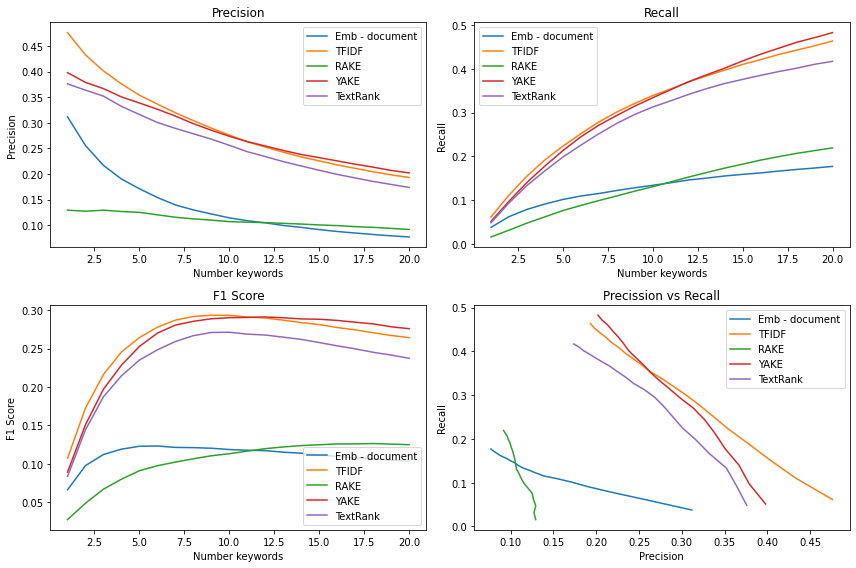

In [13]:
fig = plt.figure(figsize=(12,8))
fig.patch.set_facecolor('white')

scores = (
    ("Precision", precisions),
    ("Recall", recalls),
    ("F1 Score", f_scores),
)
for i, (title, sc) in enumerate(scores):
    plt.subplot(2, 2, i + 1)
    for p, (l, _) in zip(sc, methods):
        plt.plot(range(1, 21), p, label=l)
    plt.legend()
    plt.title(title)
    plt.xlabel("Number keywords")
    plt.ylabel(title)
        
plt.subplot(2, 2, 4)
for p, r, (l, _) in zip(precisions, recalls, methods):
    plt.plot(p, r, label=l)
    plt.legend()
    plt.title("Precission vs Recall")
    plt.xlabel("Precision")
    plt.ylabel("Recall")

plt.tight_layout()

Iz grafov lahko sklepamo, da se na primeru člankov podatkovnega nabora Schutz najbolje obneseta metodi TF-IDF in YAKE!. Sledi TextRank. Najslabše se obnese metoda RAKE.